# Demo EfficientLoFTR on a single pair of images

This notebook shows how to use the eloftr matcher with different model type and numerical precision on the pretrained weights.

In [1]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

## Outdoor Example

We recommend using our pre-trained model for input in outdoor environments because our model has only been trained on MegaDepth, and there exists a domain gap between indoor and outdoor data.

In [4]:
torch.serialization.get_unsafe_globals_in_checkpoint("weights/eloftr_conf2.ckpt")

['pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint']

In [4]:
from src.loftr import LoFTR, full_default_cfg, opt_default_cfg, reparameter
# from pytorch_lightning.callbacks import ModelCheckpoint

# You can choose model type in ['full', 'opt']
model_type = 'full' # 'full' for best quality, 'opt' for best efficiency

# You can choose numerical precision in ['fp32', 'mp', 'fp16']. 'fp16' for best efficiency
precision = 'fp32' # Enjoy near-lossless precision with Mixed Precision (MP) / FP16 computation if you have a modern GPU (recommended NVIDIA architecture >= SM_70).

# You can also change the default values like thr. and npe (based on input image size)

if model_type == 'full':
    _default_cfg = deepcopy(full_default_cfg)
elif model_type == 'opt':
    _default_cfg = deepcopy(opt_default_cfg)
    
if precision == 'mp':
    _default_cfg['mp'] = True
elif precision == 'fp16':
    _default_cfg['half'] = True
    
print(_default_cfg)
matcher = LoFTR(config=_default_cfg)
# torch.serialization.add_safe_globals([ModelCheckpoint])

matcher.load_state_dict(torch.load("weights/eloftr_outdoor.ckpt", weights_only=False)['state_dict'], strict=False)
matcher = reparameter(matcher) # no reparameterization will lead to low performance

if precision == 'fp16':
    matcher = matcher.half()

matcher = matcher.eval().cuda()

{'backbone_type': 'RepVGG', 'align_corner': False, 'resolution': (8, 1), 'fine_window_size': 8, 'mp': False, 'replace_nan': True, 'half': False, 'backbone': {'block_dims': [64, 128, 256]}, 'coarse': {'d_model': 256, 'd_ffn': 256, 'nhead': 8, 'layer_names': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'], 'agg_size0': 4, 'agg_size1': 4, 'no_flash': False, 'rope': True, 'npe': [832, 832, 832, 832]}, 'match_coarse': {'thr': 0.2, 'border_rm': 2, 'dsmax_temperature': 0.1, 'skip_softmax': False, 'fp16matmul': False, 'train_coarse_percent': 0.2, 'train_pad_num_gt_min': 200}, 'match_fine': {'local_regress_temperature': 10.0, 'local_regress_slicedim': 8}}
LoFTR: self.depth_conf=-1, n_layers=8


Early stop check at layer 1
Layer 1: 0.0
Early stop check at layer 2
Layer 2: 0.0
Early stop check at layer 3
Layer 3: 0.00125
Early stop check at layer 4
Layer 4: 0.01015625
Early stop check at layer 5
Layer 5: 0.006796875
Early stop check at layer 6
Layer 6: 0.0315625
Early stop check at layer 7


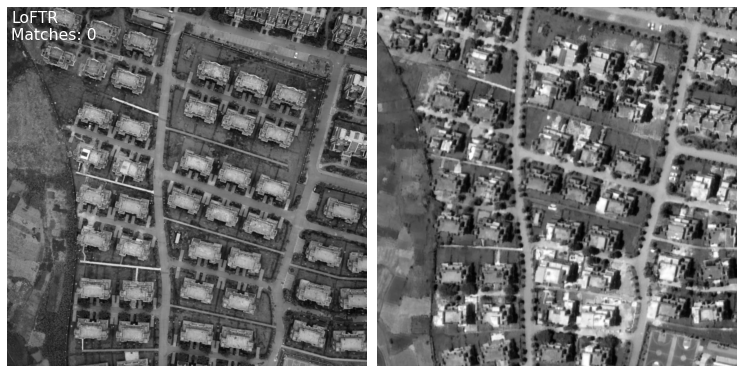

In [5]:
matcher.loftr_coarse.depth_conf = 0.8

# Load example images
img0_pth = "../_Experiments/clean_patches/01_0001_drone640.png"
img1_pth = "../_Experiments/clean_patches/01_0001_sat640.png"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//32*32, img0_raw.shape[0]//32*32))  # input size shuold be divisible by 32
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//32*32, img1_raw.shape[0]//32*32))

if precision == 'fp16':
    img0 = torch.from_numpy(img0_raw)[None][None].half().cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].half().cuda() / 255.
else:
    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with EfficientLoFTR and get prediction
with torch.no_grad():
    if precision == 'mp':
        with torch.autocast(enabled=True, device_type='cuda'):
            matcher(batch)
    else:
        matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

# Draw
if model_type == 'opt':
    print(mconf.max())
    mconf = (mconf - min(20.0, mconf.min())) / (max(30.0, mconf.max()) - min(20.0, mconf.min()))

color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

In [10]:
import cv2
import torch
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Load example images
img0_pth = "EfficientLoFTR/assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "EfficientLoFTR/assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//32*32, img0_raw.shape[0]//32*32))
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//32*32, img1_raw.shape[0]//32*32))

if precision == 'fp16':
    img0 = torch.from_numpy(img0_raw)[None][None].half().cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].half().cuda() / 255.
else:
    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.

batch = {'image0': img0, 'image1': img1}

# Inference
with torch.no_grad():
    if precision == 'mp':
        with torch.autocast(enabled=True, device_type='cuda'):
            matcher(batch)
    else:
        matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

# Normalize confidence for optical flow models
if model_type == 'opt':
    print(mconf.max())
    mconf = (mconf - min(20.0, mconf.min())) / (max(30.0, mconf.max()) - min(20.0, mconf.min()))

# Visualization
color = cm.jet(mconf)
text = [
    'LoFTR',
    f'Matches: {len(mkpts0)}',
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

# Save figure
output_path = "loftr_matches_visualization.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)
plt.close(fig)

print(f"Saved visualization to {output_path}")


Saved visualization to loftr_matches_visualization.png


In [1]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

import glob
import time
from src.loftr import LoFTR, full_default_cfg, reparameter
import gc  # for garbage collection
from tqdm import tqdm

def get_model(cfg):
    _default_cfg = deepcopy(cfg)
    model = LoFTR(config=_default_cfg)
    model.load_state_dict(torch.load("weights/eloftr_outdoor.ckpt", weights_only=False)['state_dict'], strict=False)
    model = reparameter(model) # no reparameterization will lead to low performance
    
    return model.cuda().eval()

def run(model, pairs):
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    for a,b in tqdm(pairs, total=len(pairs)):
        Ia = torch.tensor(cv2.imread(a,0)/255.,dtype=torch.float32)[None,None].cuda()
        Ib = torch.tensor(cv2.imread(b,0)/255.,dtype=torch.float32)[None,None].cuda()
        with torch.no_grad(): model({'image0':Ia,'image1':Ib})
    torch.cuda.synchronize()
    return (time.perf_counter()-t0)/len(pairs)*1000

def cleanup_model(model):
    del model  # Delete the model reference
    gc.collect()  # Run Python garbage collection
    torch.cuda.empty_cache()  # Clear unused memory in CUDA

In [2]:
pairs = list(zip(sorted(glob.glob('../../Data/Datasets/uav-visloc-loftr/val/images/*_drone.png')),
                 sorted(glob.glob('../../Data/Datasets/uav-visloc-loftr/val/images/*_sat.png'))))

pairs = pairs[:1] # for quick test

model = get_model(full_default_cfg)
print('baseline  ms/pair:', run(model, pairs))

confidences = [0.5, 0.5, 0.6, 0.7, 0.8, 0.9]
for c in confidences:
    full_default_cfg['coarse']['depth_confidence'] = c
    model = get_model(full_default_cfg)
    model.depth_conf = c
    print('conf', c, 'ms/pair:', run(model, pairs))


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


baseline  ms/pair: 373.7322369997855


100%|██████████| 1/1 [00:00<00:00, 24.43it/s]


conf 0.5 ms/pair: 41.976432999945246


100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


conf 0.5 ms/pair: 39.71856299904175


100%|██████████| 1/1 [00:00<00:00, 25.84it/s]


conf 0.6 ms/pair: 39.69303300254978


100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


conf 0.7 ms/pair: 38.94955900250352


100%|██████████| 1/1 [00:00<00:00, 26.36it/s]


conf 0.8 ms/pair: 38.95496000041021


100%|██████████| 1/1 [00:00<00:00, 26.17it/s]

conf 0.9 ms/pair: 39.323901997704525


In [3]:
# AirSim
import pandas as pd
suffix = 'val'
dataset_dir = '../../Data/AirSim/Ch1'
pairs_df = pd.read_csv(os.path.join('../../Data/AirSim/Ch1/pair_csv/', 'pair_list_' + suffix + '.csv'))
pairs_df = pairs_df[pairs_df['label'] == 1]

pairs_df["path0"] = pairs_df["image0"].apply(lambda x: os.path.join(dataset_dir, x))
pairs_df["path1"] = pairs_df["image1"].apply(lambda x: os.path.join(dataset_dir, x))
pairs = pairs_df[["path0", "path1"]].values.tolist()

pairs = pairs[:100] # for quick test

model = get_model(full_default_cfg)
model.depth_conf = -1
print('baseline  ms/pair:', run(model, pairs))

confidences = [0.5, 0.6, 0.7, 0.8, 0.9]
for c in confidences:
    model.depth_conf = c
    print('conf', c, 'ms/pair:', run(model, pairs))


INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
100%|██████████| 100/100 [00:09<00:00, 10.90it/s]


baseline  ms/pair: 91.76463185001921


100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


conf 0.5 ms/pair: 91.70715219999693


100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


conf 0.6 ms/pair: 92.00609158997395


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


conf 0.7 ms/pair: 92.6327743100046


100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


conf 0.8 ms/pair: 95.48924742000963


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]

conf 0.9 ms/pair: 100.12092717999622
